<a href="https://colab.research.google.com/github/finardi/tutos/blob/master/Forced_Alignment_Torchaudio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install torchaudio
!pip install transformers
!pip install soundfile

# Libs

In [2]:
import os

import torch

import IPython
import torchaudio
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from dataclasses import dataclass
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor

matplotlib.rcParams['figure.figsize'] = [22, 6]

torch.random.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(torch.__version__)
print(torchaudio.__version__)
print(device)

1.10.0+cu111
0.10.0+cu111
cpu


# Model

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_name = 'lgris/wav2vec2-large-xlsr-open-brazilian-portuguese-v2'

model = Wav2Vec2ForCTC.from_pretrained(model_name).to(device)
processor = Wav2Vec2Processor.from_pretrained(model_name)

Downloading:   0%|          | 0.00/1.32k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.18G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/212 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/138 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/409 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Audio Metadata

AudioMetaData(sample_rate=48000, num_frames=143040, num_channels=1, bits_per_sample=16, encoding=PCM_S)


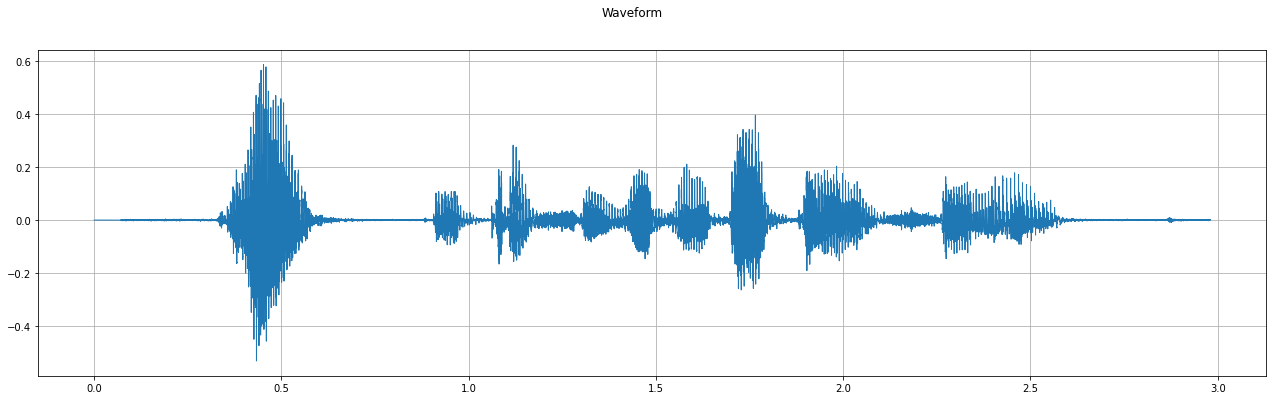

In [4]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

# -------------------------------------
SPEECH_FILE = "/content/drive/MyDrive/Wav2Vec/data/audio_paulo.wav"

metadata = torchaudio.info(SPEECH_FILE)
print(metadata)

waveform, sample_rate = torchaudio.load(SPEECH_FILE)
plot_waveform(waveform, sample_rate)

IPython.display.Audio(SPEECH_FILE)

# Predict

In [5]:
resampler = torchaudio.transforms.Resample(orig_freq=48_000, new_freq=16_000)

waveform, sample_rate = torchaudio.load(SPEECH_FILE)
waveform = resampler.forward(waveform.squeeze(0)).numpy()

features = processor(waveform, sampling_rate=16_000, padding=True, return_tensors="pt")

input_values = features.input_values.to(device)
attention_mask = features.attention_mask.to(device)

with torch.no_grad():
    logits = model(input_values, attention_mask=attention_mask)['logits']

pred_ids = torch.argmax(logits, dim=-1)
predicted = processor.batch_decode(pred_ids)
predicted = [pred.lower() for pred in predicted]

print(f'\nTranscription:\n\t{predicted[0]}\n')

emissions = torch.log_softmax(logits, dim=-1)
emission = logits[0].cpu().detach()

/usr/local/lib/python3.7/dist-packages/transformers/models/wav2vec2/modeling_wav2vec2.py:1093: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  return (input_length - kernel_size) // stride + 1



Transcription:
	oi eu preciso de um cartão adicional



# Labels

In [6]:
dictionary = processor.tokenizer.get_vocab()
dictionary = {k.lower():v for k,v in dictionary.items()}
labels = tuple(list(map(lambda x: x, dictionary.keys())))

dictionary

{'': 0,
 '-': 35,
 '</s>': 2,
 '<pad>': 1,
 '<s>': 44,
 '<unk>': 3,
 'a': 5,
 'b': 24,
 'c': 16,
 'd': 12,
 'e': 6,
 'f': 21,
 'g': 20,
 'h': 22,
 'i': 10,
 'j': 30,
 'k': 42,
 'l': 17,
 'm': 13,
 'n': 11,
 'o': 7,
 'p': 18,
 'q': 23,
 'r': 9,
 's': 8,
 't': 14,
 'u': 15,
 'v': 19,
 'w': 43,
 'x': 31,
 'y': 41,
 'z': 29,
 '|': 4,
 'à': 37,
 'á': 28,
 'â': 40,
 'ã': 25,
 'ç': 26,
 'é': 27,
 'ê': 34,
 'í': 32,
 'ó': 33,
 'ô': 39,
 'õ': 36,
 'ú': 38}

In [7]:
logits.shape # (N, SEQ_LEN, VOCAB)

torch.Size([1, 148, 44])

In [8]:
outs = processor.tokenizer.convert_ids_to_tokens(pred_ids[0].tolist())
outs = [elel.lower() for elel in outs]
print(outs)
print('-'.join(outs))

['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'o', '', '', '', '', '', '', 'i', '', '|', '|', '|', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'e', '', 'u', '|', '|', '', '', 'p', '', 'r', 'e', '', '', '', '', '', '', '', 'c', 'i', '', '', '', '', 's', 'o', '|', '|', '|', '', 'd', 'e', '|', 'u', 'u', 'm', '|', '|', 'c', '', 'a', '', 'r', '', '', '', '', '', 't', 'ã', '', 'o', '|', '|', '|', 'a', '', '', 'd', '', 'i', '', '', '', '', 'c', 'i', '', 'o', 'o', '', '', '', '', 'n', 'a', '', '', '', '', 'l', '|', '|', '|', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
-------------------o-------i--|-|-|----------------e--u-|-|---p--r-e--------c-i-----s-o-|-|-|--d-e-|-u-u-m-|-|-c--a--r------t-ã--o-|-|-|-a---d--i-----c-i--o-o-----n-a-----l-|-|-|------------------


# Trellis

[('o', 7), ('i', 10), ('|', 4), ('e', 6), ('u', 15), ('|', 4), ('p', 18), ('r', 9), ('e', 6), ('c', 16), ('i', 10), ('s', 8), ('o', 7), ('|', 4), ('d', 12), ('e', 6), ('|', 4), ('u', 15), ('m', 13), ('|', 4), ('c', 16), ('a', 5), ('r', 9), ('t', 14), ('ã', 25), ('o', 7), ('|', 4), ('a', 5), ('d', 12), ('i', 10), ('c', 16), ('i', 10), ('o', 7), ('n', 11), ('a', 5), ('l', 17)]


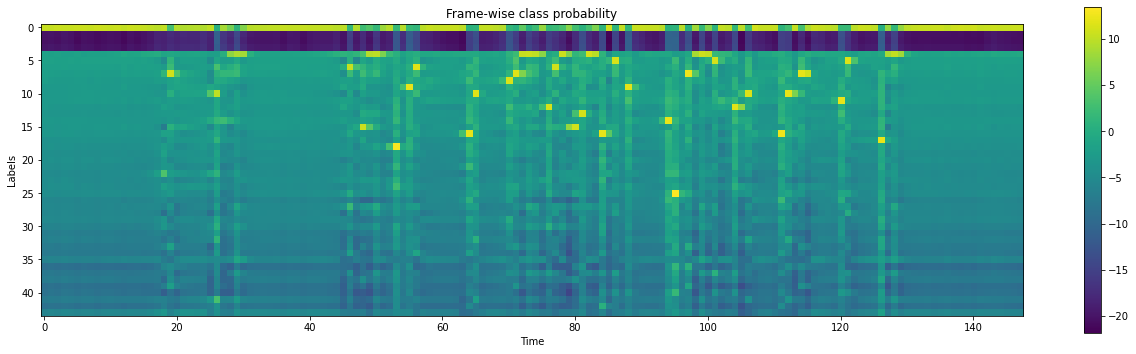

In [9]:
transcript = predicted[0].replace(' ', '|')
# dictionary  = {c: i for i, c in enumerate(labels)}

tokens = [dictionary[c] for c in transcript]
print(list(zip(transcript, tokens)))

def get_trellis(emission, tokens, blank_id=0):
  num_frame = emission.size(0)
  num_tokens = len(tokens)

  # Trellis has extra dimensions for both time axis and tokens.
  # The extra dim for tokens represents <SoS> (start-of-sentence)
  # The extra dim for time axis is for simplification of the code.
  trellis = torch.full((num_frame+1, num_tokens+1), -float('inf'))
  trellis[:, 0] = 0
  for t in range(num_frame):
    trellis[t+1, 1:] = torch.maximum(
        # Score for staying at the same token
        trellis[t, 1:] + emission[t, blank_id],
        # Score for changing to the next token
        trellis[t, :-1] + emission[t, tokens],
    )
  return trellis

trellis = get_trellis(emission, tokens)

# ----------------------------------
plt.imshow(emission.T)
plt.colorbar()
plt.title("Frame-wise class probability")
plt.xlabel("Time")
plt.ylabel("Labels")
plt.show()

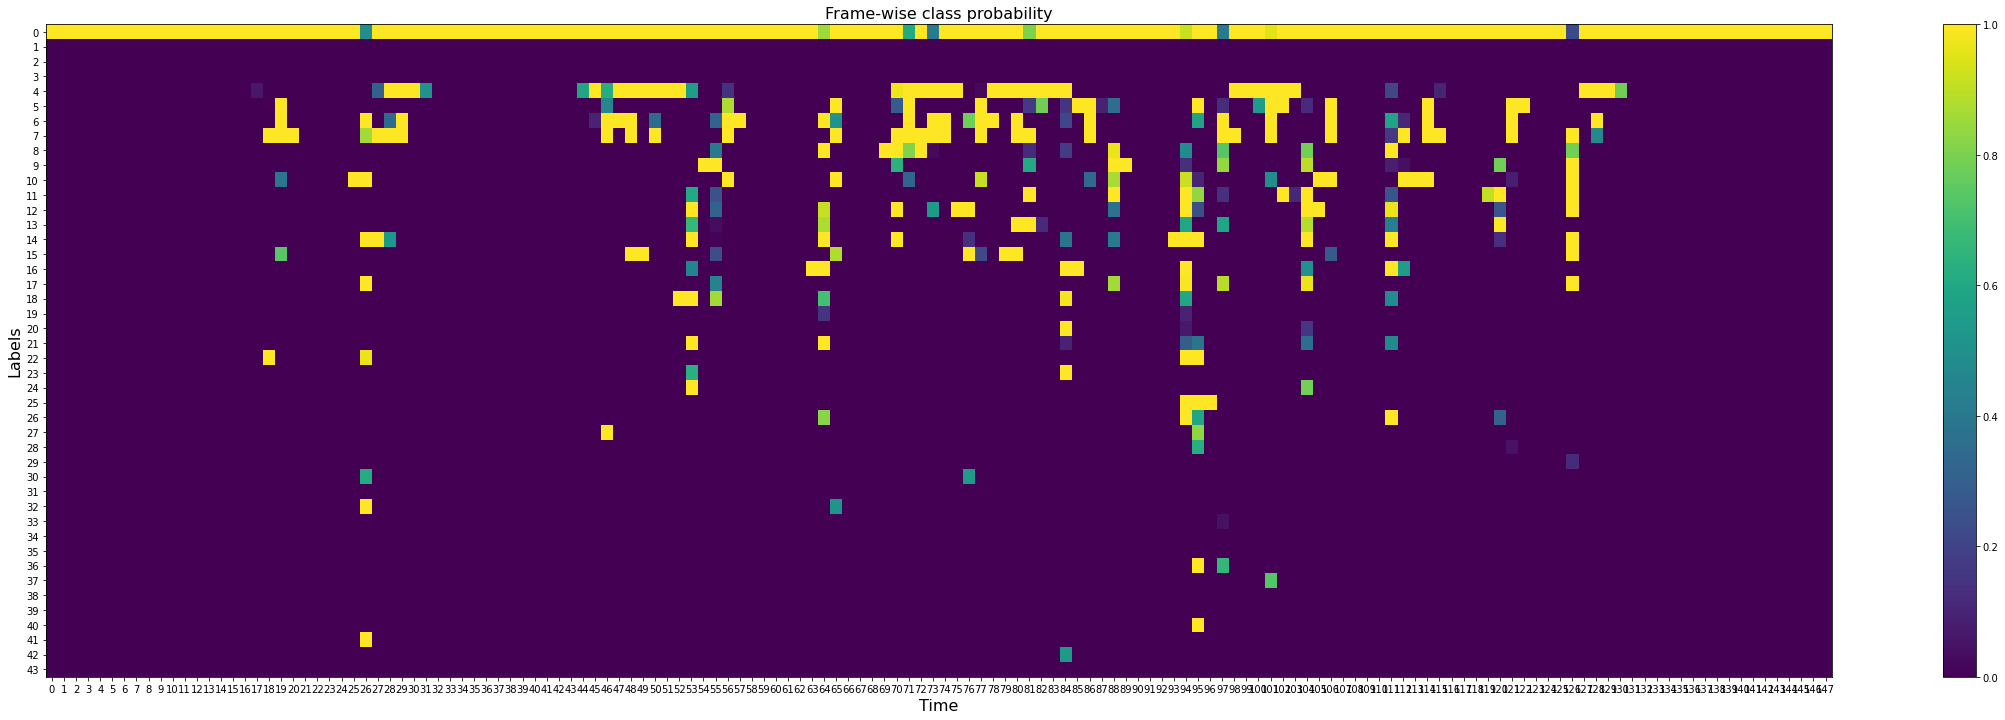

In [10]:
# Same pic normalized

plt.rcParams['figure.figsize'] = [40, 12]
plt.imshow(emission.T, vmin=0, vmax=1, aspect='auto')
plt.colorbar()
plt.title("Frame-wise class probability", fontsize=16)
plt.xlabel("Time", fontsize=16)
plt.yticks(np.arange(logits.shape[-1]).tolist())
plt.xticks(np.arange(logits.shape[1]).tolist())
plt.ylabel("Labels", fontsize=16)
plt.show()

In [11]:
print('-'.join(outs))

-------------------o-------i--|-|-|----------------e--u-|-|---p--r-e--------c-i-----s-o-|-|-|--d-e-|-u-u-m-|-|-c--a--r------t-ã--o-|-|-|-a---d--i-----c-i--o-o-----n-a-----l-|-|-|------------------


In [21]:
char_search = 'o'
for pos in [idx for idx, elel in enumerate(outs) if elel == char_search]:
    print(f'char {char_search}: pos_xy {dictionary[char_search], pos}') 

char o: pos_xy (7, 19)
char o: pos_xy (7, 71)
char o: pos_xy (7, 97)
char o: pos_xy (7, 114)
char o: pos_xy (7, 115)


In [13]:
logits[0][19]

tensor([  2.8911, -17.4774, -17.7951, -17.3842,  -0.7224,   1.3202,   2.1745,
         11.0957,  -1.4505,  -1.6596,   0.3925,  -2.2632,  -2.4352,  -2.7147,
         -2.9202,   0.7411,  -1.6598,  -2.3396,  -3.2092,  -3.8616,  -5.0523,
         -3.4574,  -2.1204,  -4.1459,  -3.1195,  -2.7494,  -6.0003,  -3.5059,
         -5.0188,  -6.9065,  -4.9467,  -7.7490,  -6.2997,  -1.4995,  -6.2326,
         -7.9677,  -4.8672,  -5.4511,  -4.4624,  -1.9395,  -8.5086,  -7.2350,
         -8.2684,  -6.0285])

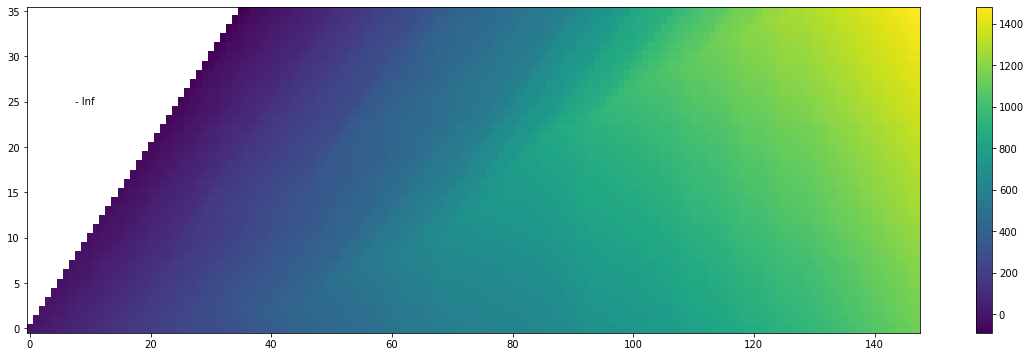

In [14]:
matplotlib.rcParams['figure.figsize'] = [20, 6]
plt.imshow(trellis[1:, 1:].T, origin='lower', aspect='auto')
plt.annotate("- Inf", (trellis.size(1) / 5, trellis.size(1) / 1.5))
plt.colorbar()
plt.show()

In [15]:
@dataclass
class Point:
  token_index: int
  time_index: int
  score: float

def backtrack(trellis, emission, tokens, blank_id=0):
  # Note:
  # j and t are indices for trellis, which has extra dimensions
  # for time and tokens at the beginning.
  # When refering to time frame index `T` in trellis,
  # the corresponding index in emission is `T-1`.
  # Similarly, when refering to token index `J` in trellis,
  # the corresponding index in transcript is `J-1`.
  j = trellis.size(1) - 1
  t_start = torch.argmax(trellis[:, j]).item()

  path = []
  for t in range(t_start, 0, -1):
    # 1. Figure out if the current position was stay or change
    # Note (again):
    # `emission[J-1]` is the emission at time frame `J` of trellis dimension.
    # Score for token staying the same from time frame J-1 to T.
    stayed = trellis[t-1, j] + emission[t-1, blank_id]
    # Score for token changing from C-1 at T-1 to J at T.
    changed = trellis[t-1, j-1] + emission[t-1, tokens[j-1]]

    # 2. Store the path with frame-wise probability.
    prob = emission[t-1, tokens[j-1] if changed > stayed else 0].exp().item()
    # Return token index and time index in non-trellis coordinate.
    path.append(Point(j-1, t-1, prob))

    # 3. Update the token
    if changed > stayed:
      j -= 1
      if j == 0:
        break
  else:
    raise ValueError('Failed to align')
  return path[::-1]

path = backtrack(trellis, emission, tokens)
print(path)

[Point(token_index=0, time_index=0, score=0.14807288348674774), Point(token_index=0, time_index=1, score=33473.25), Point(token_index=0, time_index=2, score=40235.796875), Point(token_index=0, time_index=3, score=34813.80859375), Point(token_index=0, time_index=4, score=35594.625), Point(token_index=0, time_index=5, score=42537.25), Point(token_index=0, time_index=6, score=39436.6484375), Point(token_index=0, time_index=7, score=39251.51953125), Point(token_index=0, time_index=8, score=46218.375), Point(token_index=0, time_index=9, score=39563.63671875), Point(token_index=0, time_index=10, score=38120.0703125), Point(token_index=0, time_index=11, score=44647.70703125), Point(token_index=0, time_index=12, score=27604.833984375), Point(token_index=0, time_index=13, score=40257.40625), Point(token_index=0, time_index=14, score=37138.78125), Point(token_index=0, time_index=15, score=31918.076171875), Point(token_index=0, time_index=16, score=24420.49609375), Point(token_index=0, time_index

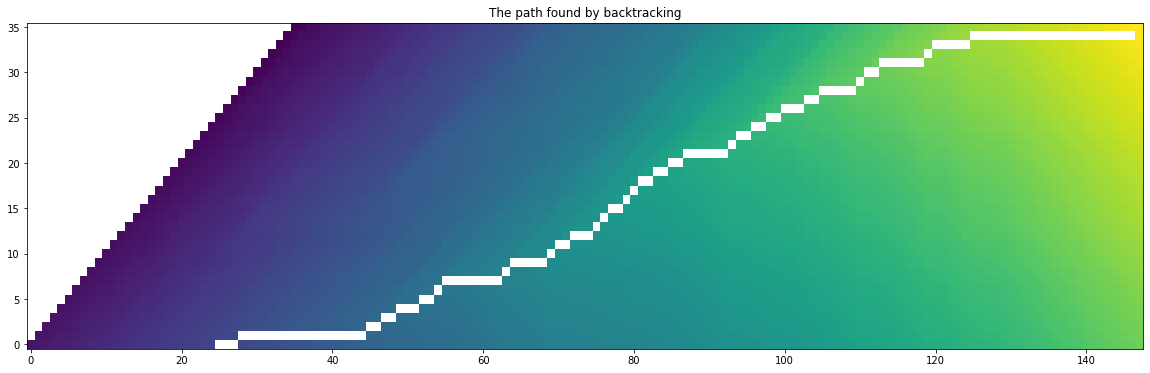

In [16]:
def plot_trellis_with_path(trellis, path):
  # To plot trellis with path, we take advantage of 'nan' value
  trellis_with_path = trellis.clone()
  for i, p in enumerate(path):
    trellis_with_path[p.time_index, p.token_index] = float('nan')
  plt.imshow(trellis_with_path[1:, 1:].T, origin='lower', aspect='auto')

plot_trellis_with_path(trellis, path)
plt.title("The path found by backtracking")
plt.show()

In [17]:
# Merge the labels
@dataclass
class Segment:
  label: str
  start: int
  end: int
  score: float

  def __repr__(self):
    return f"{self.label}\t({self.score:4.2f}): [{self.start:5d}, {self.end:5d})"

  @property
  def length(self):
    return self.end - self.start

def merge_repeats(path):
  i1, i2 = 0, 0
  segments = []
  while i1 < len(path):
    while i2 < len(path) and path[i1].token_index == path[i2].token_index:
      i2 += 1
    score = sum(path[k].score for k in range(i1, i2)) / (i2 - i1)
    segments.append(Segment(transcript[path[i1].token_index], path[i1].time_index, path[i2-1].time_index + 1, score))
    i1 = i2
  return segments

segments = merge_repeats(path)
for seg in segments:
  print(seg)

o	(27831.82): [    0,    26)
i	(10396.58): [   26,    29)
|	(22245.05): [   29,    46)
e	(25084.70): [   46,    48)
u	(19688.36): [   48,    50)
|	(14290.23): [   50,    53)
p	(253345.72): [   53,    55)
r	(211080.83): [   55,    56)
e	(42525.06): [   56,    64)
c	(207189.53): [   64,    65)
i	(42956.89): [   65,    70)
s	(98084.78): [   70,    71)
o	(65153.82): [   71,    73)
|	(14094.83): [   73,    76)
d	(83415.92): [   76,    77)
e	(52328.39): [   77,    78)
|	(20848.37): [   78,    80)
u	(53009.70): [   80,    81)
m	(73790.57): [   81,    82)
|	(35470.58): [   82,    84)
c	(122598.65): [   84,    86)
a	(56167.53): [   86,    88)
r	(55779.69): [   88,    94)
t	(208710.81): [   94,    95)
ã	(363956.73): [   95,    97)
o	(141864.75): [   97,    99)
|	(26296.29): [   99,   101)
a	(41264.76): [  101,   104)
d	(77014.94): [  104,   106)
i	(54185.53): [  106,   111)
c	(274150.34): [  111,   112)
i	(113911.62): [  112,   114)
o	(55257.55): [  114,   120)
n	(221669.70): [  120,   121)
a	(4

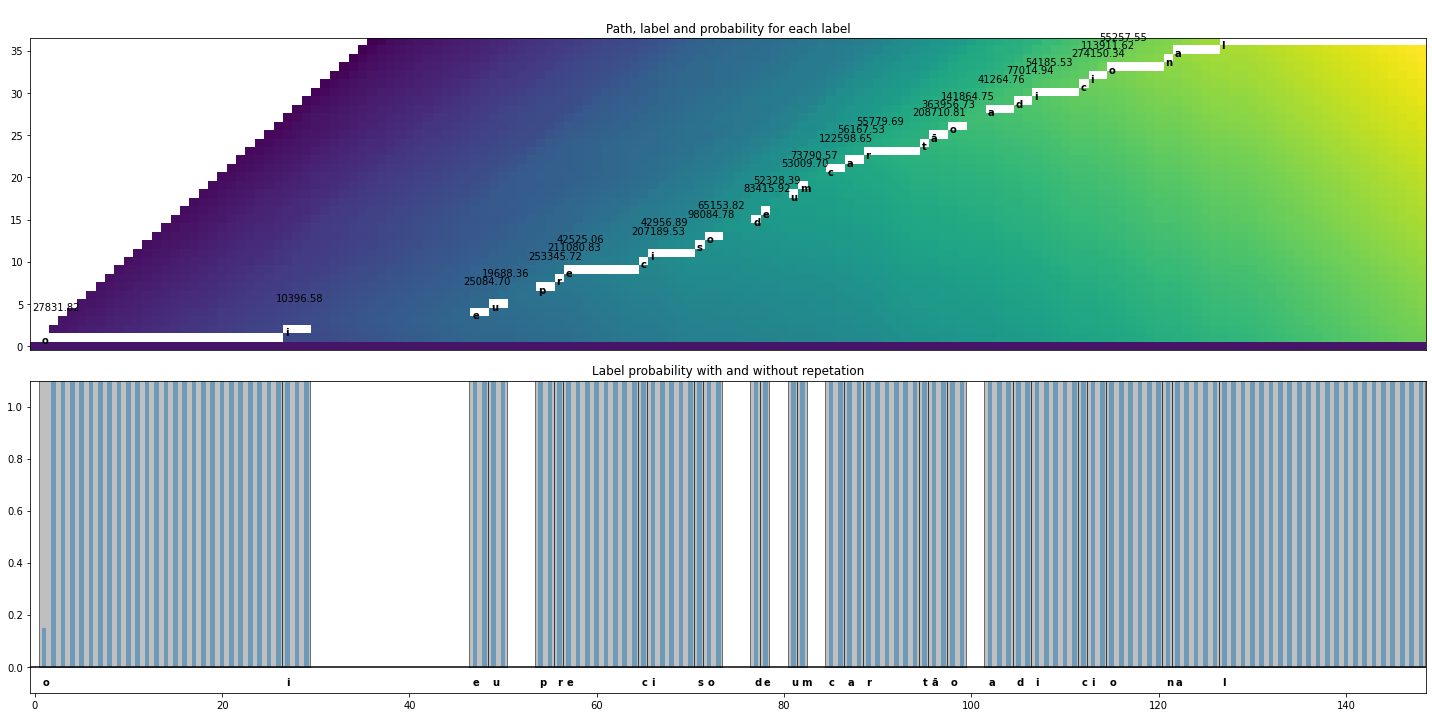

In [18]:
def plot_trellis_with_segments(trellis, segments, transcript):
  # To plot trellis with path, we take advantage of 'nan' value
  trellis_with_path = trellis.clone()
  for i, seg in enumerate(segments):
    if seg.label != '|':
      trellis_with_path[seg.start+1:seg.end+1, i+1] = float('nan')

  fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(20, 10))
  ax1.set_title("Path, label and probability for each label")
  ax1.imshow(trellis_with_path.T, origin='lower', aspect='auto')
  ax1.set_xticks([])

  for i, seg in enumerate(segments):
    if seg.label != '|':
      ax1.annotate(seg.label, (seg.start + .7, i + 0.3), weight='bold')
      ax1.annotate(f'{seg.score:.2f}', (seg.start - .3, i + 4.3))

  ax2.set_title("Label probability with and without repetation")
  xs, hs, ws = [], [], []
  for seg in segments:
    if seg.label != '|':
      xs.append((seg.end + seg.start) / 2 + .4)
      hs.append(seg.score)
      ws.append(seg.end - seg.start)
      ax2.annotate(seg.label, (seg.start + .8, -0.07), weight='bold')
  ax2.bar(xs, hs, width=ws, color='gray', alpha=0.5, edgecolor='black')

  xs, hs = [], []
  for p in path:
    label = transcript[p.token_index]
    if label != '|':
      xs.append(p.time_index + 1)
      hs.append(p.score)

  ax2.bar(xs, hs, width=0.5, alpha=0.5)
  ax2.axhline(0, color='black')
  ax2.set_xlim(ax1.get_xlim())
  ax2.set_ylim(-0.1, 1.1)

plot_trellis_with_segments(trellis, segments, transcript)
plt.tight_layout()
plt.show()

In [19]:
# Merge words
def merge_words(segments, separator='|'):
  words = []
  i1, i2 = 0, 0
  while i1 < len(segments):
    if i2 >= len(segments) or segments[i2].label == separator:
      if i1 != i2:
        segs = segments[i1:i2]
        word = ''.join([seg.label for seg in segs])
        score = sum(seg.score * seg.length for seg in segs) / sum(seg.length for seg in segs)
        words.append(Segment(word, segments[i1].start, segments[i2-1].end, score))
      i1 = i2 + 1
      i2 = i1
    else:
      i2 += 1
  return words

word_segments = merge_words(segments)
for word in word_segments:
  print(word)

oi	(26028.18): [    0,    29)
eu	(22386.53): [   46,    50)
preciso	(85416.96): [   53,    73)
de	(67872.16): [   76,    78)
um	(63400.13): [   80,    82)
cartão	(127504.29): [   84,    99)
adicional	(59145.00): [  101,   148)


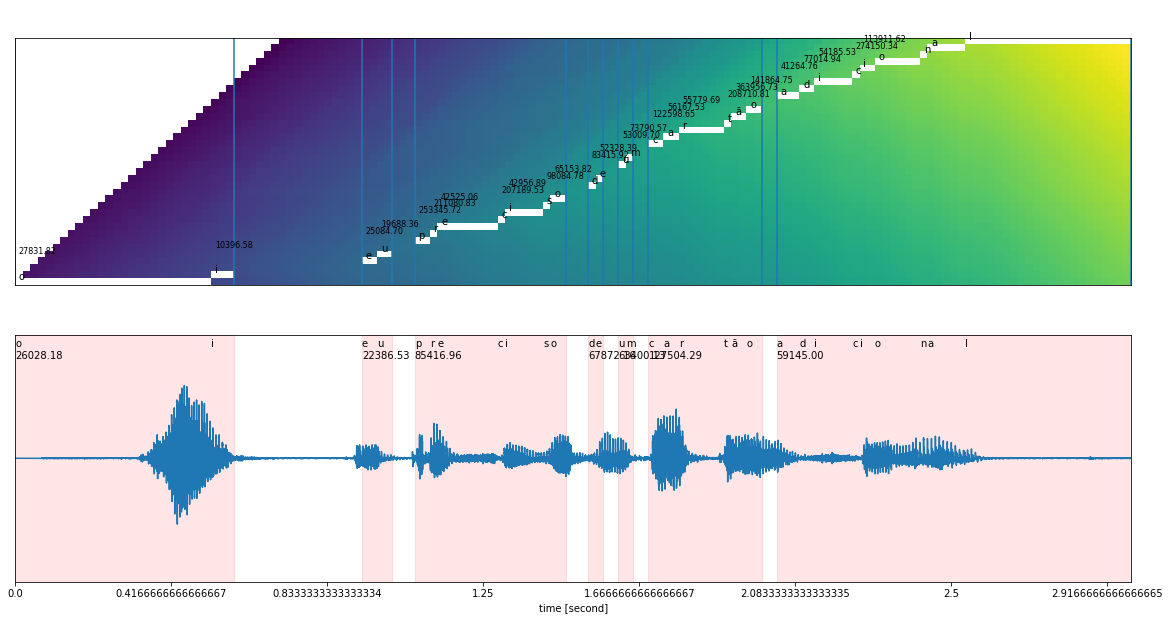

In [20]:
waveform, _ = torchaudio.load(SPEECH_FILE)

def plot_alignments(trellis, segments, word_segments, waveform):
  trellis_with_path = trellis.clone()
  for i, seg in enumerate(segments):
    if seg.label != '|':
      trellis_with_path[seg.start+1:seg.end+1, i+1] = float('nan')

  fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(20, 10))

  ax1.imshow(trellis_with_path[1:, 1:].T, origin='lower', aspect='auto')
  ax1.set_xticks([])
  ax1.set_yticks([])

  for word in word_segments:
    ax1.axvline(word.start - 0.5)
    ax1.axvline(word.end - 0.5)

  for i, seg in enumerate(segments):
    if seg.label != '|':
      ax1.annotate(seg.label, (seg.start, i + 0.3))
      ax1.annotate(f'{seg.score:.2f}', (seg.start , i + 4), fontsize=8)

  # The original waveform
  ratio = waveform.size(0) / (trellis.size(0) - 1)
  ax2.plot(waveform)
  for word in word_segments:
    x0 = ratio * word.start
    x1 = ratio * word.end
    ax2.axvspan(x0, x1, alpha=0.1, color='red')
    ax2.annotate(f'{word.score:.2f}', (x0, 0.8))

  for seg in segments:
    if seg.label != '|':
      ax2.annotate(seg.label, (seg.start * ratio, 0.9))
  xticks = ax2.get_xticks()
  plt.xticks(xticks, xticks / 48_000)
  ax2.set_xlabel('time [second]')
  ax2.set_yticks([])
  ax2.set_ylim(-1.0, 1.0)
  ax2.set_xlim(0, waveform.size(-1))

plot_alignments(trellis, segments, word_segments, waveform[0],)
plt.show()

# A trick to embed the resulting audio to the generated file.
# `IPython.display.Audio` has to be the last call in a cell,
# and there should be only one call par cell.
def display_segment(i):
  ratio = waveform.size(1) / (trellis.size(0) - 1)
  word = word_segments[i]
  x0 = int(ratio * word.start)
  x1 = int(ratio * word.end)
  filename = f"_assets/{i}_{word.label}.wav"
  torchaudio.save(filename, waveform[:, x0:x1], bundle.sample_rate)
  print(f"{word.label} ({word.score:.2f}): {x0 / bundle.sample_rate:.3f} - {x1 / bundle.sample_rate:.3f} sec")
  return IPython.display.Audio(filename)